Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt


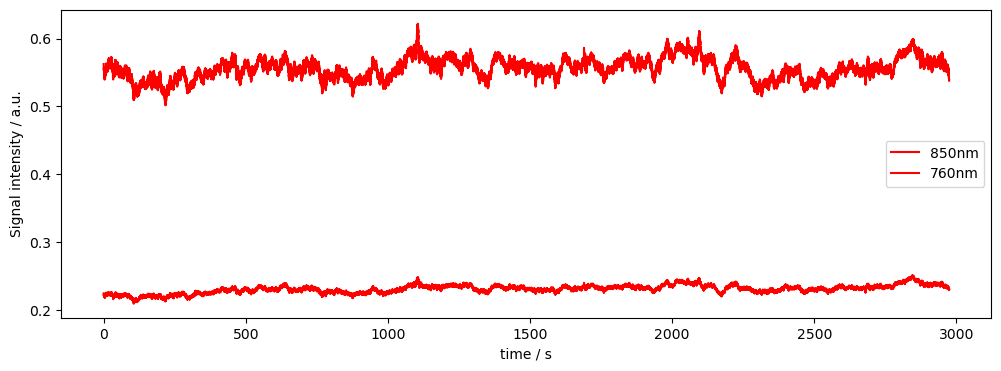

In [1]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.sigproc.motion_correct as motion_correct
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
import cedalion.plots as plots
from cedalion import units
import numpy as np

import cedalion.sim.synthetic_artifact as sa

rec = datasets.get_fingertapping()
rec["od"] = cedalion.nirs.int2od(rec["amp"])

f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S3D3", wavelength="850"), "r-", label="850nm")
ax.plot( rec["amp"].time, rec["amp"].sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

display(rec["amp"])





## Artifact Generation

Artifacts are generated by functions taking as arguments: 
- time axis of timeseries 
- onset time 
- duration

To enable proper scaling, the amplitude of the generic artifact generated by these functions should be 1.

<xarray.DataArray 'time' (time: 23239)> Size: 186kB
array([0., 0., 0., ..., 1., 1., 1.])
Coordinates:
  * time     (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03

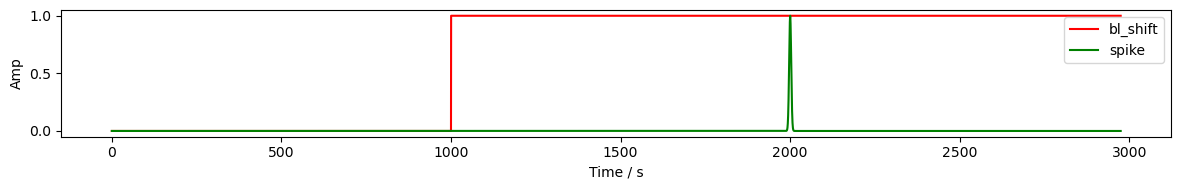

In [7]:
time = rec["amp"].time
sample_bl_shift = sa.gen_bl_shift(time, 1000)
sample_spike = sa.gen_spike(time, 2000, 3)

display(sample_bl_shift)

fig, ax =  p.subplots(1, 1, figsize=(12,2))
ax.plot(time, sample_bl_shift, "r-", label="bl_shift")
ax.plot(time, sample_spike, "g-", label="spike")
ax.set_xlabel('Time / s')
ax.set_ylabel('Amp')
ax.legend()


p.tight_layout()
p.show()

## Controlling Artifact Timing

Artifacts can be placed using a timing dataframe with columns onset_time, duration, trial_type, value, and channel.

We can use the function add_event_timing to create and modify timing dataframes. The function allows precise control over each event.

We can also use the functions random_events_num and random_events_perc to add random events to the dataframe—specifying either the number of events or the percentage of the timeseries duration, respectively.

In [ ]:
# Create a list of events in the format (onset, duration)
events = [(1000, 1), (2000, 1)]

# Creates a new timing dataframe with the specified events.
# Setting channel to None indicates that the artifact applies to all channels.
timing_amp = sa.add_event_timing(events, 'bl_shift', None)

# Add random events to the timing dataframe
timing_od = sa.random_events_perc(time, 0.001, ["spike"], 0.1, 0.4, timing)

display(timing_amp)
display(timing_od)

## Adding Artifacts to Data

The function add_artifacts automatically scales artifacts and adds them to timeseries data. The function takes arguments
- ts: cdt.NDTimeSeries
- timing: pd.DataFrame
- artifacts: Dict

The artifact functions (see above) are passed as a dictionary. Keys correspond to entries in the column trial_type of the timing dataframe, i.e. each event specified in the timing dataframe is generated using the function artifacts[trial_type].


,onset,duration,trial_type,value,channel
0,2000,1,bl_shift,1,None
1,1000,1,bl_shift,1,None


Computed alphas: {('S1D1', 760.0): 0.003980300000000006, ('S1D2', 760.0): 0.007666299999999987, ('S1D3', 760.0): 0.004548200000000002, ('S1D9', 760.0): 0.0009467999999999976, ('S2D1', 760.0): 0.01737999999999995, ('S2D3', 760.0): 0.01064900000000002, ('S2D4', 760.0): 0.004725500000000021, ('S2D10', 760.0): 0.0019369999999999943, ('S3D2', 760.0): 0.0030898999999999996, ('S3D3', 760.0): 0.009041700000000014, ('S3D11', 760.0): 0.0013376999999999972, ('S4D3', 760.0): 0.011911999999999978, ('S4D4', 760.0): 0.0047588000000000075, ('S4D12', 760.0): 0.003042299999999998, ('S5D5', 760.0): 0.005231100000000016, ('S5D6', 760.0): 0.0048869, ('S5D7', 760.0): 0.030253799999999997, ('S5D13', 760.0): 0.0025284000000000417, ('S6D5', 760.0): 0.018584299999999998, ('S6D7', 760.0): 0.011230199999999968, ('S6D8', 760.0): 0.0030951000000000034, ('S6D14', 760.0): 0.002961699999999984, ('S7D6', 760.0): 0.004581199999999994, ('S7D7', 760.0): 0.011398699999999984, ('S7D15', 760.0): 0.0018442999999999932, ('S8D7

,onset,duration,trial_type,value,channel
0,2887.225466,0.296736,spike,1,None
1,1681.901037,0.260979,spike,1,None
2,2488.059119,0.375985,spike,1,None
3,68.931940,0.373187,spike,1,None
4,2073.042412,0.143552,spike,1,None
5,2150.073013,0.129649,spike,1,None
6,1642.446497,0.334686,spike,1,None
7,354.588401,0.278121,spike,1,None
8,2310.408244,0.225634,spike,1,None
9,1808.602374,0.103202,spike,1,None


Computed alphas: {('S1D1', 760.0): 0.04073283396280941, ('S1D2', 760.0): 0.03271400895441624, ('S1D3', 760.0): 0.03738130201177692, ('S1D9', 760.0): 0.012840348247313144, ('S2D1', 760.0): 0.028016684432979916, ('S2D3', 760.0): 0.03629686987328909, ('S2D4', 760.0): 0.026468428857197517, ('S2D10', 760.0): 0.011075136698022712, ('S3D2', 760.0): 0.04967063018446393, ('S3D3', 760.0): 0.03846873733517468, ('S3D11', 760.0): 0.008204127473010917, ('S4D3', 760.0): 0.03694125943642686, ('S4D4', 760.0): 0.04442935274692535, ('S4D12', 760.0): 0.009435780631691785, ('S5D5', 760.0): 0.035949355746329875, ('S5D6', 760.0): 0.0338468182632097, ('S5D7', 760.0): 0.0391833278109493, ('S5D13', 760.0): 0.009603979174319478, ('S6D5', 760.0): 0.030476872654582557, ('S6D7', 760.0): 0.030132111239724008, ('S6D8', 760.0): 0.0339175348423833, ('S6D14', 760.0): 0.013035844263654232, ('S7D6', 760.0): 0.054887096386723705, ('S7D7', 760.0): 0.0451832388137042, ('S7D15', 760.0): 0.010313702252608112, ('S8D7', 760.0): 

Magnitude,[[[0.081062640136786 0.0852423802696924 0.08485778601188877 ... -0.029683560725465557 -0.028748460893748475 -0.033398646871495415] [0.07916172781426532 0.07541821706070692 0.09015032570809943 ... -0.031824985222312516 -0.029098061378167877 -0.024901958405035424]] [[0.024849899441379313 0.015285906978259597 0.030931223569737064 ... -0.03597636853223378 -0.038927534000745806 -0.03705567312839769] [0.005639287699804969 0.0022221195186715808 0.014633930631984537 ... -0.03422576919244229 -0.0365252730071311 -0.03709431043454637]] [[0.13814341678105713 0.1367280627720406 0.14877544633616793 ... -0.06314117466924873 -0.05843155236334288 -0.05875480607287077] [0.09670632752930183 0.094320094757801 0.10693144420280391 ... -0.050409795762233894 -0.04682909280868861 -0.04975004966688769]] ... [[0.1333709615574613 0.14892364508842157 0.14478514145635352 ... -0.07302615747786138 -0.07029371997315172 -0.07785450860385487] [0.09395345799106172 0.11823767696762151 0.11665584562340976 ... -0.04589556088672926 -0.046468924849952846 -0.05574980832828615]] [[0.19335783225700565 0.21043670440013537 0.20709949538602673 ... -0.10120683675570533 -0.10105068716041651 -0.10566570450781157] [0.15467153475900206 0.1783337783184203 0.1783618662880057 ... -0.08714209436125511 -0.08692473408992901 -0.09339094192349566]] [[0.06863965249955091 0.071838006546753 0.07142150797954532 ... -0.029414424702282376 -0.029262991119963937 -0.03057609060961648] [0.03895127226752738 0.04546089291999574 0.046764800247526786 ... -0.025380013632490254 -0.02523483384172004 -0.02740217050763962]]]
Units,dimensionless


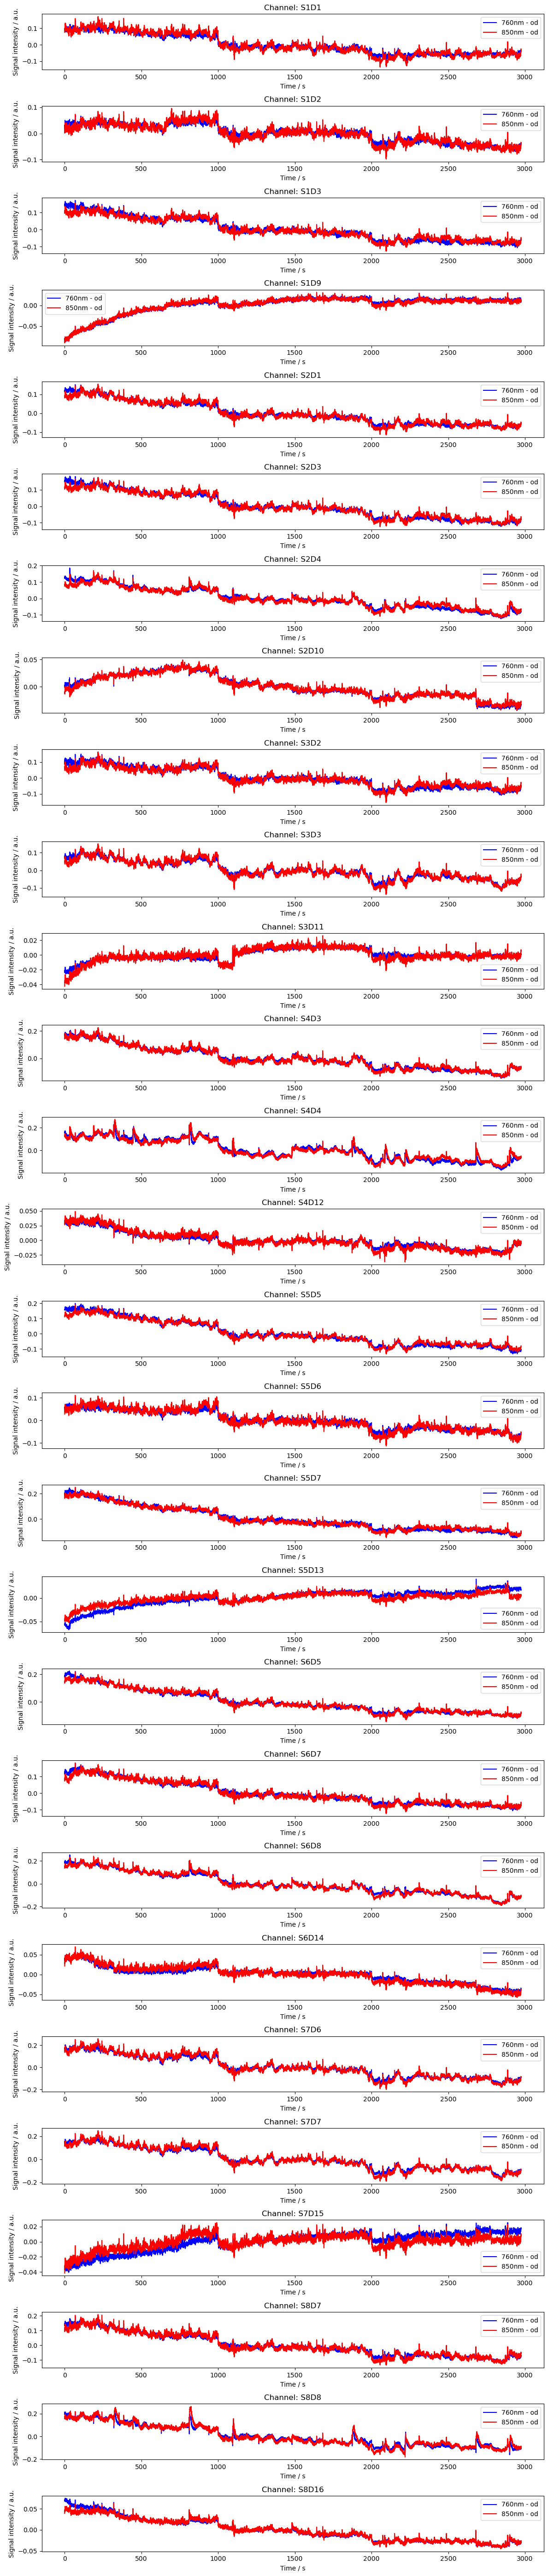

In [2]:
artifacts = {"spike": sa.gen_spike, "bl_shift": sa.gen_bl_shift}

# Add baseline shifts to the amp data
rec["amp"] = sa.add_artifacts(rec["amp"], timing_amp, artifacts)

# Convert the amp data to optical density
rec["od"] = cedalion.nirs.int2od(rec["amp"])

# Add the spikes to OD
rec["od"] = sa.add_artifacts(rec["od"], timing, artifacts)

# Plot the data
channels = rec["od"].channel.values
fig, axes = p.subplots(len(channels), 1, figsize=(12, len(channels)*2))
if len(channels) == 1:
    axes = [axes]
for i, channel in enumerate(channels):
    ax = axes[i]
    ax.plot(rec["od"].time, rec["od"].sel(channel=channel, wavelength="760"), 'b-', label='760nm - od')
    ax.plot(rec["od"].time, rec["od"].sel(channel=channel, wavelength="850"), 'r-', label='850nm - od')
    ax.set_title(f'Channel: {channel}')
    ax.set_xlabel('Time / s')
    ax.set_ylabel('Signal intensity / a.u.')
    ax.legend()
p.tight_layout()
p.show()

Adding spike at 1933.992598968843 for 14.95019245559934 to all channels
Adding spike at 166.60680031737544 for 648.8974902689747 to all channels
Adding bl_shift at 2142.0304542886083 for 83.74485236524531 to all channels


Text(0, 0.5, 'Signal intensity / a.u.')

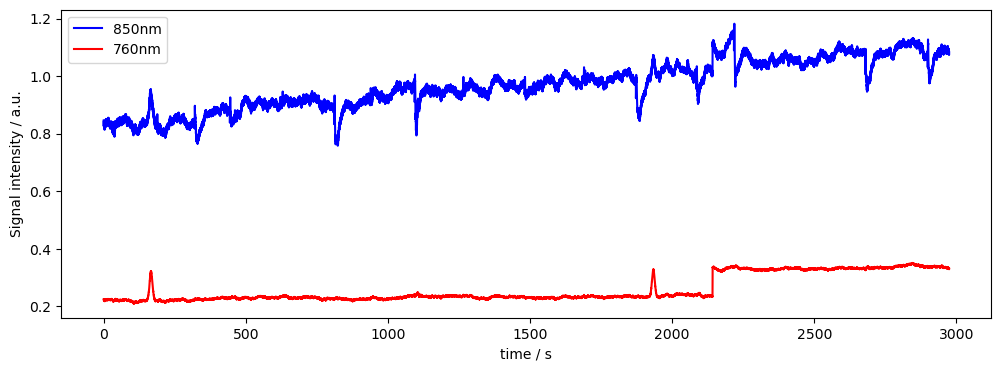

In [3]:
rand_arts = sa.gen_random_events(rec["amp"].time, 3, ['spike', 'bl_shift'])
rec["amp_art_rand"] = sa.add_artifacts_amp(rec["amp"], rand_arts)

f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( rec["amp_art_rand"].time, rec["amp_art_rand"].sel(channel="S8D8", wavelength="850"), "b-", label="850nm")
ax.plot( rec["amp_art_rand"].time, rec["amp_art_rand"].sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")